<a href="https://colab.research.google.com/github/richayanamandra/GenAI-Experiments/blob/main/genAI_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import make_grid, save_image
from collections import Counter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("generated_samples", exist_ok=True)
os.makedirs("final_generated_images", exist_ok=True)


In [5]:
dataset_choice='mnist'
epochs=50
batch_size=64
noise_dim=100
learning_rate=0.0002
save_interval=5


In [6]:
#Load Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

if dataset_choice == "mnist":
    train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
elif dataset_choice == "fashion":
    train_data = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
else:
    raise ValueError("Dataset must be 'mnist' or 'fashion'")

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.2MB/s]


In [22]:
#Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [23]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [24]:
criterion = nn.BCELoss()


In [25]:
search_space = {
    "lr": [learning_rate, learning_rate / 2],
    "noise": [noise_dim, noise_dim * 2]
}


In [26]:
def train_gan_test(lr, zdim, test_epochs=5):
    G = Generator(zdim).to(device)
    D = Discriminator().to(device)

    opt_G = optim.Adam(G.parameters(), lr=lr)
    opt_D = optim.Adam(D.parameters(), lr=lr)

    for epoch in range(test_epochs):
        for real, _ in train_loader:
            real = real.view(-1, 784).to(device)
            batch = real.size(0)

            # Train D
            z = torch.randn(batch, zdim).to(device)
            fake = G(z)

            real_labels = torch.ones(batch, 1).to(device)
            fake_labels = torch.zeros(batch, 1).to(device)

            loss_D = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)
            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # Train G
            loss_G = criterion(D(fake), real_labels)
            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

    return loss_G.item()


In [27]:
best_loss = float("inf")
best_params = None

for lr in search_space["lr"]:
    for z in search_space["noise"]:
        print(f"Testing lr={lr}, noise_dim={z}")
        loss = train_gan_test(lr, z)
        print("G_loss:", loss)

        if loss < best_loss:
            best_loss = loss
            best_params = (lr, z)

print("\nBest Params:", best_params)


Testing lr=0.0001, noise_dim=200
G_loss: 10.945610046386719
Testing lr=0.0001, noise_dim=400
G_loss: 13.466307640075684
Testing lr=5e-05, noise_dim=200
G_loss: 5.473160266876221
Testing lr=5e-05, noise_dim=400
G_loss: 5.686705589294434

Best Params: (5e-05, 200)


In [28]:
learning_rate, noise_dim = best_params

G = Generator(noise_dim).to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=learning_rate * 0.5, betas=(0.5, 0.999))


In [29]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_samples(samples, title="Generated Samples", save_path=None):
    samples = (samples + 1) / 2  # Rescale from [-1,1] to [0,1]
    grid = make_grid(samples, nrow=5)

    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(title)
    plt.show()

    if save_path:
        from torchvision.utils import save_image
        save_image(samples, save_path, nrow=5)


Epoch 1/50 | D_loss: 1.08 | D_acc: 60.59% | G_loss: 1.06
Epoch 2/50 | D_loss: 1.04 | D_acc: 61.52% | G_loss: 1.22
Epoch 3/50 | D_loss: 0.81 | D_acc: 74.23% | G_loss: 1.25
Epoch 4/50 | D_loss: 0.78 | D_acc: 72.14% | G_loss: 1.40
Epoch 5/50 | D_loss: 0.74 | D_acc: 80.37% | G_loss: 1.16


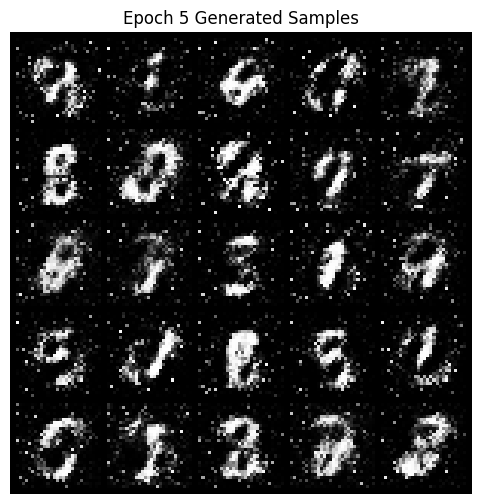

Epoch 6/50 | D_loss: 0.86 | D_acc: 79.80% | G_loss: 1.03
Epoch 7/50 | D_loss: 0.73 | D_acc: 70.98% | G_loss: 1.72
Epoch 8/50 | D_loss: 0.85 | D_acc: 64.26% | G_loss: 1.74
Epoch 9/50 | D_loss: 1.05 | D_acc: 59.15% | G_loss: 1.66
Epoch 10/50 | D_loss: 1.42 | D_acc: 87.80% | G_loss: 0.41


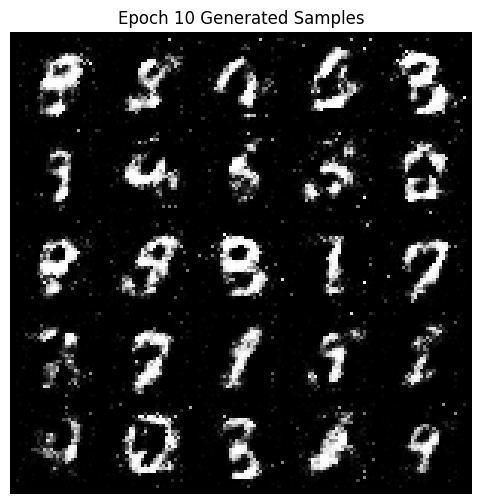

Epoch 11/50 | D_loss: 0.84 | D_acc: 65.21% | G_loss: 1.47
Epoch 12/50 | D_loss: 1.20 | D_acc: 38.59% | G_loss: 2.30
Epoch 13/50 | D_loss: 1.05 | D_acc: 58.44% | G_loss: 1.20
Epoch 14/50 | D_loss: 1.05 | D_acc: 54.36% | G_loss: 1.46
Epoch 15/50 | D_loss: 1.03 | D_acc: 55.70% | G_loss: 1.49


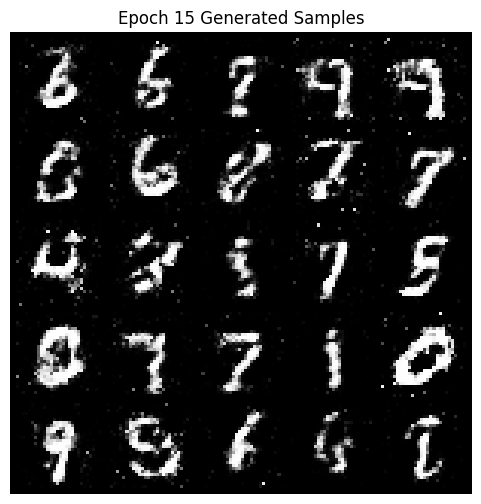

Epoch 16/50 | D_loss: 1.00 | D_acc: 61.76% | G_loss: 1.28
Epoch 17/50 | D_loss: 1.10 | D_acc: 52.87% | G_loss: 1.38
Epoch 18/50 | D_loss: 1.14 | D_acc: 72.29% | G_loss: 0.72
Epoch 19/50 | D_loss: 1.17 | D_acc: 47.28% | G_loss: 1.42
Epoch 20/50 | D_loss: 1.05 | D_acc: 65.08% | G_loss: 1.07


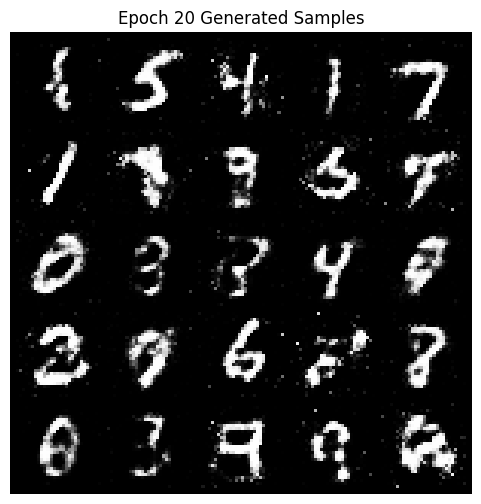

Epoch 21/50 | D_loss: 1.09 | D_acc: 51.75% | G_loss: 1.42
Epoch 22/50 | D_loss: 1.15 | D_acc: 73.71% | G_loss: 0.66
Epoch 23/50 | D_loss: 1.09 | D_acc: 67.55% | G_loss: 0.92
Epoch 24/50 | D_loss: 1.07 | D_acc: 55.91% | G_loss: 1.29
Epoch 25/50 | D_loss: 1.20 | D_acc: 64.10% | G_loss: 0.83


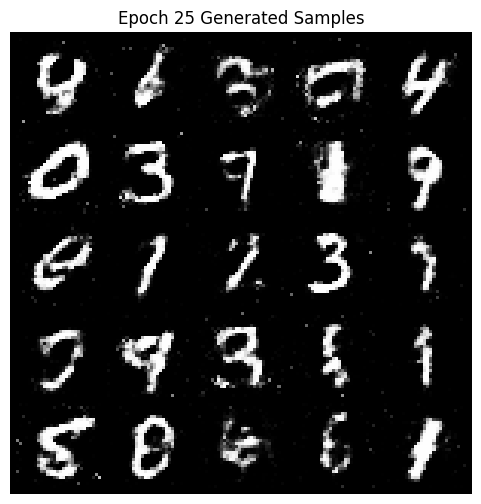

Epoch 26/50 | D_loss: 1.06 | D_acc: 58.76% | G_loss: 1.23
Epoch 27/50 | D_loss: 1.22 | D_acc: 63.80% | G_loss: 0.83
Epoch 28/50 | D_loss: 1.28 | D_acc: 72.93% | G_loss: 0.64
Epoch 29/50 | D_loss: 1.20 | D_acc: 60.36% | G_loss: 0.93
Epoch 30/50 | D_loss: 1.14 | D_acc: 70.02% | G_loss: 0.80


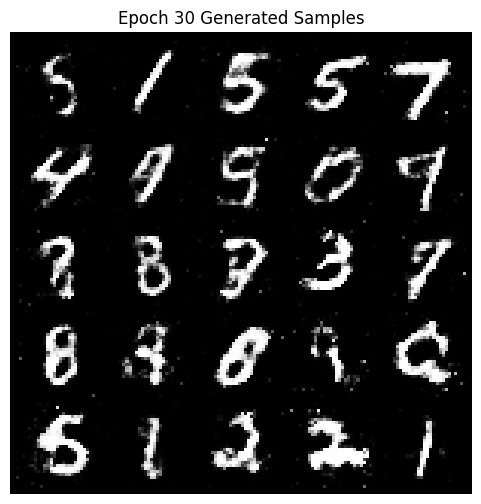

Epoch 31/50 | D_loss: 1.29 | D_acc: 42.39% | G_loss: 1.61
Epoch 32/50 | D_loss: 1.23 | D_acc: 43.57% | G_loss: 1.73
Epoch 33/50 | D_loss: 1.15 | D_acc: 55.36% | G_loss: 1.17
Epoch 34/50 | D_loss: 1.09 | D_acc: 57.92% | G_loss: 1.26
Epoch 35/50 | D_loss: 1.20 | D_acc: 72.57% | G_loss: 0.76


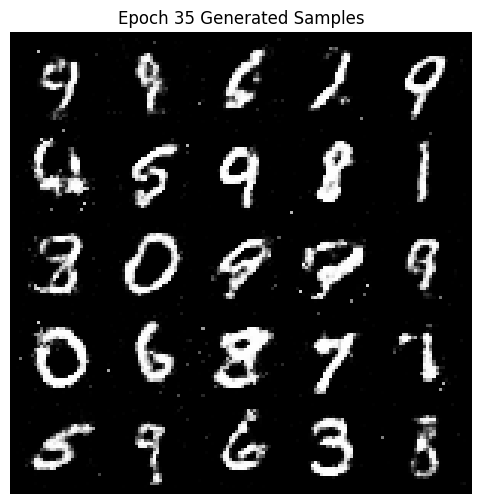

Epoch 36/50 | D_loss: 1.24 | D_acc: 51.80% | G_loss: 1.21
Epoch 37/50 | D_loss: 1.02 | D_acc: 68.93% | G_loss: 1.04
Epoch 38/50 | D_loss: 1.17 | D_acc: 52.33% | G_loss: 1.34
Epoch 39/50 | D_loss: 1.12 | D_acc: 51.69% | G_loss: 1.42
Epoch 40/50 | D_loss: 1.00 | D_acc: 60.47% | G_loss: 1.26


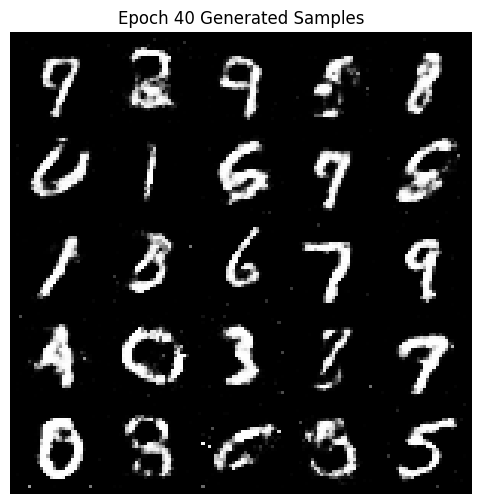

Epoch 41/50 | D_loss: 1.15 | D_acc: 63.38% | G_loss: 1.00
Epoch 42/50 | D_loss: 1.01 | D_acc: 71.38% | G_loss: 1.00
Epoch 43/50 | D_loss: 1.07 | D_acc: 69.40% | G_loss: 0.94
Epoch 44/50 | D_loss: 1.14 | D_acc: 64.85% | G_loss: 0.99
Epoch 45/50 | D_loss: 1.12 | D_acc: 72.35% | G_loss: 0.84


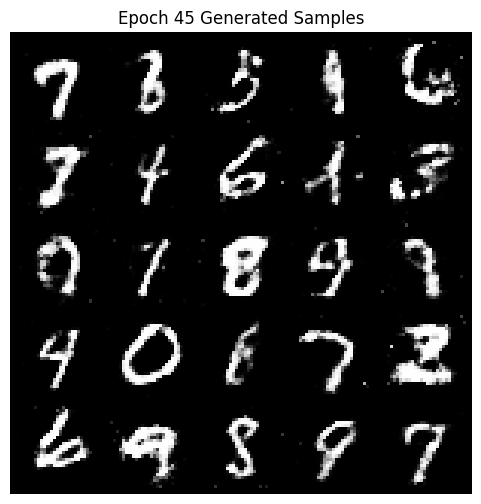

Epoch 46/50 | D_loss: 1.09 | D_acc: 48.70% | G_loss: 1.63
Epoch 47/50 | D_loss: 1.22 | D_acc: 71.78% | G_loss: 0.83
Epoch 48/50 | D_loss: 1.18 | D_acc: 66.36% | G_loss: 0.95
Epoch 49/50 | D_loss: 1.37 | D_acc: 45.69% | G_loss: 1.34
Epoch 50/50 | D_loss: 1.23 | D_acc: 58.90% | G_loss: 1.11


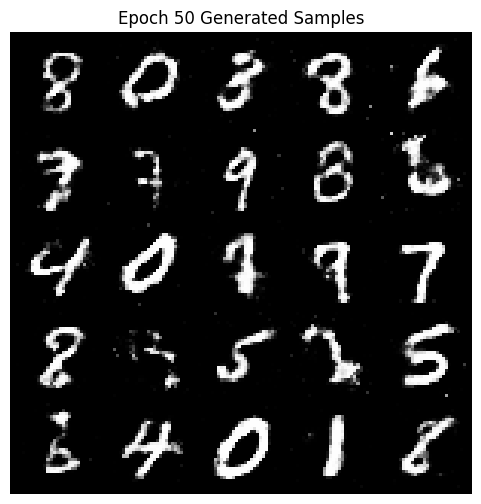

In [30]:
for epoch in range(1, epochs + 1):
    for real, _ in train_loader:
        real = real.view(-1, 784).to(device)
        batch = real.size(0)

        real_labels = torch.ones(batch, 1).to(device)
        fake_labels = torch.zeros(batch, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch, noise_dim).to(device)
        fake = G(z)

        loss_D = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        loss_G = criterion(D(fake), real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    D_acc = (D(real).mean().item()) * 100

    print(f"Epoch {epoch}/{epochs} | D_loss: {loss_D.item():.2f} | D_acc: {D_acc:.2f}% | G_loss: {loss_G.item():.2f}")

    if epoch % save_interval == 0:
      z = torch.randn(25, noise_dim).to(device)
      samples = G(z).view(-1, 1, 28, 28)

      show_samples(
        samples,
        title=f"Epoch {epoch} Generated Samples",
        save_path=f"{BASE_PATH}/generated_samples/epoch_{epoch:02d}.png" if 'BASE_PATH' in globals() else None
      )



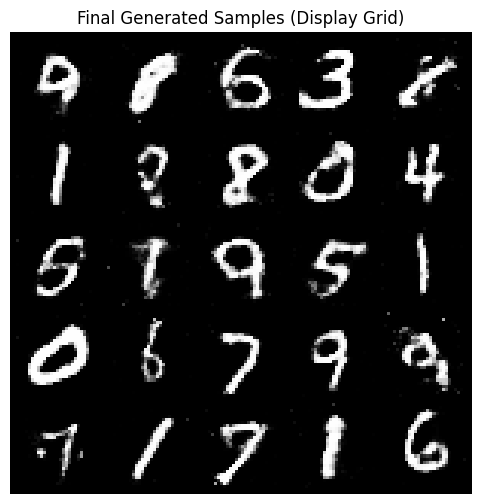

In [31]:
#Final 100 images
z = torch.randn(25, noise_dim).to(device)
final_display = G(z).view(-1, 1, 28, 28)

show_samples(final_display, title="Final Generated Samples (Display Grid)")


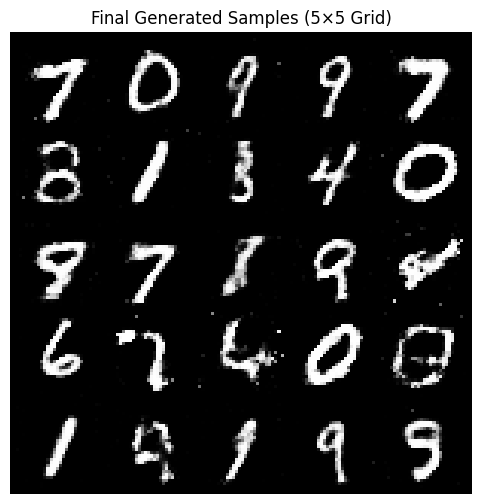

In [32]:
import os
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

FINAL_PATH = "final_generated_images"
os.makedirs(FINAL_PATH, exist_ok=True)

G.eval()

z = torch.randn(100, noise_dim).to(device)
with torch.no_grad():
    final_samples = G(z).view(-1, 1, 28, 28)

# Rescale from [-1,1] → [0,1]
final_samples = (final_samples + 1) / 2

# Save individual images
for i in range(100):
    save_image(final_samples[i], f"{FINAL_PATH}/img_{i+1:03d}.png")

# Display grid in output
grid = make_grid(final_samples[:25], nrow=5)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Final Generated Samples (5×5 Grid)")
plt.show()


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [36]:
class DigitCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [37]:
transform_cls = transforms.Compose([
    transforms.ToTensor()
])

if dataset_choice == "mnist":
    cls_train = datasets.MNIST(root="./data", train=True, transform=transform_cls, download=True)
    cls_test = datasets.MNIST(root="./data", train=False, transform=transform_cls, download=True)
else:
    cls_train = datasets.FashionMNIST(root="./data", train=True, transform=transform_cls, download=True)
    cls_test = datasets.FashionMNIST(root="./data", train=False, transform=transform_cls, download=True)

train_loader_cls = DataLoader(cls_train, batch_size=128, shuffle=True)
test_loader_cls = DataLoader(cls_test, batch_size=128, shuffle=False)


In [38]:
classifier = DigitCNN().to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=0.001)

EPOCHS_CLS = 5  # 3–5 is enough

for epoch in range(EPOCHS_CLS):
    classifier.train()
    total = 0
    correct = 0

    for x, y in train_loader_cls:
        x, y = x.to(device), y.to(device)

        preds = classifier(x)
        loss = criterion_cls(preds, y)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = 100 * correct / total
    print(f"[Classifier] Epoch {epoch+1}/{EPOCHS_CLS} | Train Acc: {acc:.2f}%")


[Classifier] Epoch 1/5 | Train Acc: 93.22%
[Classifier] Epoch 2/5 | Train Acc: 98.24%
[Classifier] Epoch 3/5 | Train Acc: 98.78%
[Classifier] Epoch 4/5 | Train Acc: 99.02%
[Classifier] Epoch 5/5 | Train Acc: 99.23%


In [39]:
from collections import Counter

classifier.eval()
label_counts = Counter()

with torch.no_grad():
    for i in range(100):
        img = final_samples[i].unsqueeze(0).to(device)
        pred = classifier(img)
        label = pred.argmax(1).item()
        label_counts[label] += 1

print("\nPredicted Label Distribution (Custom CNN):")
for k, v in sorted(label_counts.items()):
    print(f"Class {k}: {v}")



Predicted Label Distribution (Custom CNN):
Class 0: 10
Class 1: 10
Class 2: 6
Class 3: 7
Class 4: 12
Class 5: 4
Class 6: 10
Class 7: 19
Class 8: 4
Class 9: 18
